<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/425_hierarchical_models.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(mcmc-bayes-hierarchical_models)=
# Modello gerarchico beta-binomiale

Il modello gerarchico beta-binomiale è utilizzato per analizzare dati binomiali provenienti da più unità (ad esempio, individui, gruppi, o categorie) raggruppate insieme. Questo modello si basa sulla distribuzione binomiale, che è adatta per descrivere il numero di "successi" in un certo numero di prove, ciascuna delle quali ha una probabilità di successo nota. Nel contesto del modello gerarchico, assumiamo che le probabilità di successo dei singoli gruppi siano stimate da una distribuzione comune, ovvero, una distribuzione beta. 

Il modello gerarchico ci consente di combinare le informazioni provenienti da tutti i cluster di osservazioni per stimare sia i parametri del gruppo (probabilità di successo per ciascun gruppo) che i parametri del modello comune (i parametri della distribuzione beta). Questo approccio migliora la precisione delle stime e fornisce una migliore comprensione delle differenze tra i gruppi e delle caratteristiche comuni a tutti.

In questo capitolo, esploreremo come il modello gerarchico beta-binomiale può essere applicato ad un campione di dati reali e vedremo come interpretare i risultati. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import scipy.stats as stats
import arviz as az
import requests
from scipy.special import expit as logistic
from scipy.special import softmax
from io import StringIO
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

## Therapeutic touch

Consideriamo un problema discusso da {cite:t}`doing_bayesian_data_an`. Il "Therapeutic touch" è una tecnica infermieristica in cui l'operatore manipola manualmente il "campo energetico" di un paziente affetto da una malattia. L'operatore posiziona le mani vicine ma senza toccare effettivamente il paziente, riprogrammando il campo energetico per alleviare la congestione e ripristinare l'equilibrio, permettendo al corpo di guarire. {cite:t}`rosa1998close` hanno riportato che il "therapeutic touch" è ampiamente insegnato e utilizzato nelle scuole di infermieristica e negli ospedali degli Stati Uniti, nonostante ci sia poca o nessuna evidenza della sua efficacia.

{cite:t}`rosa1998close` hanno indagato una delle principali affermazioni degli operatori del "therapeutic touch", ovvero che essi possono percepire il campo energetico di una persona senza vedere le mani. Se questo fosse vero, gli operatori dovrebbero essere in grado di percepire quale delle loro mani è vicina a quella di un'altra persona, anche senza poterle vedere. Nell'esperimento che è stato eseguito, l'operatore sedeva con le mani allungate attraverso delle aperture in un pannello di cartone, che impediva di vedere l'esaminatore. Ad ogni prova, l'esaminatore lanciava una moneta e posizionava la mano a pochi centimetri sopra una delle mani dell'operatore, a seconda dell'esito del lancio della moneta. Il compito dell'operatore era di decidere su quale delle sue mani fosse stata posizionata la mano dell'esaminatore. Ogni prova veniva valutata come corretta o errata. 

Ogni operatore ha partecipato a 10 prove. Nel complesso, lo studio ha coinvolto 21 operatori, di cui sette sono stati sottoposti al test due volte, a circa un anno di distanza. I retest sono stati considerati come soggetti separati dagli autori, ottenendo così 28 soggetti nominali. Le proporzioni corrette per i 28 soggetti sono mostrate nella figura successiva. La prestazione attesa in base al caso soltanto è 0.50. La domanda della ricerca è quanto il gruppo nel suo insieme si discosti dalla prestazione attesa in base al caso, e se i singoli operatori differiscano dalla prestazione attesa in base al caso soltanto.

Iniziamo a leggere i dati messi da disposizione da {cite:t}`doing_bayesian_data_an`.

In [14]:
# Define the URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv"
# Download the content of the CSV file
response = requests.get(url)
tt_dat = pd.read_csv(StringIO(response.text))
print(tt_dat.head())

   y    s
0  1  S01
1  0  S01
2  0  S01
3  0  S01
4  0  S01


In [15]:
tt_dat.shape

(280, 2)

Nella colonna `y`, il valore 1 indica una risposta corretta, mentre 0 indica una risposta errata. La seconda colonna contiene il codice identificativo di ciascun operatore.

Calcoliamo la proporzione di risposte corrette per ciascun operatore.

In [16]:
tt_agg = tt_dat.groupby("s").agg(proportion_correct=("y", "mean")).reset_index()
tt_agg

,s,proportion_correct
0,S01,0.1
1,S02,0.2
2,S03,0.3
3,S04,0.3
4,S05,0.3
5,S06,0.3
6,S07,0.3
7,S08,0.3
8,S09,0.3
9,S10,0.3


Creiamo ora un istogramma che rappresenti le proporzioni di risposte corrette. Valori superiori a 0.5 indicano la capacità di discriminare correttamente la posizione della mano dell'esaminatore, anche senza vederla. Valori inferiori a 0.5 indicano invece che, sebbene si riesca a distinguere la posizione della mano dell'esaminatore, le risposte sbagliate sono più frequenti rispetto al caso.

La distribuzione è unimodale, con un intervallo di valori tra 0 e 1, quindi può essere adeguatamente descritta dalla densità Beta.

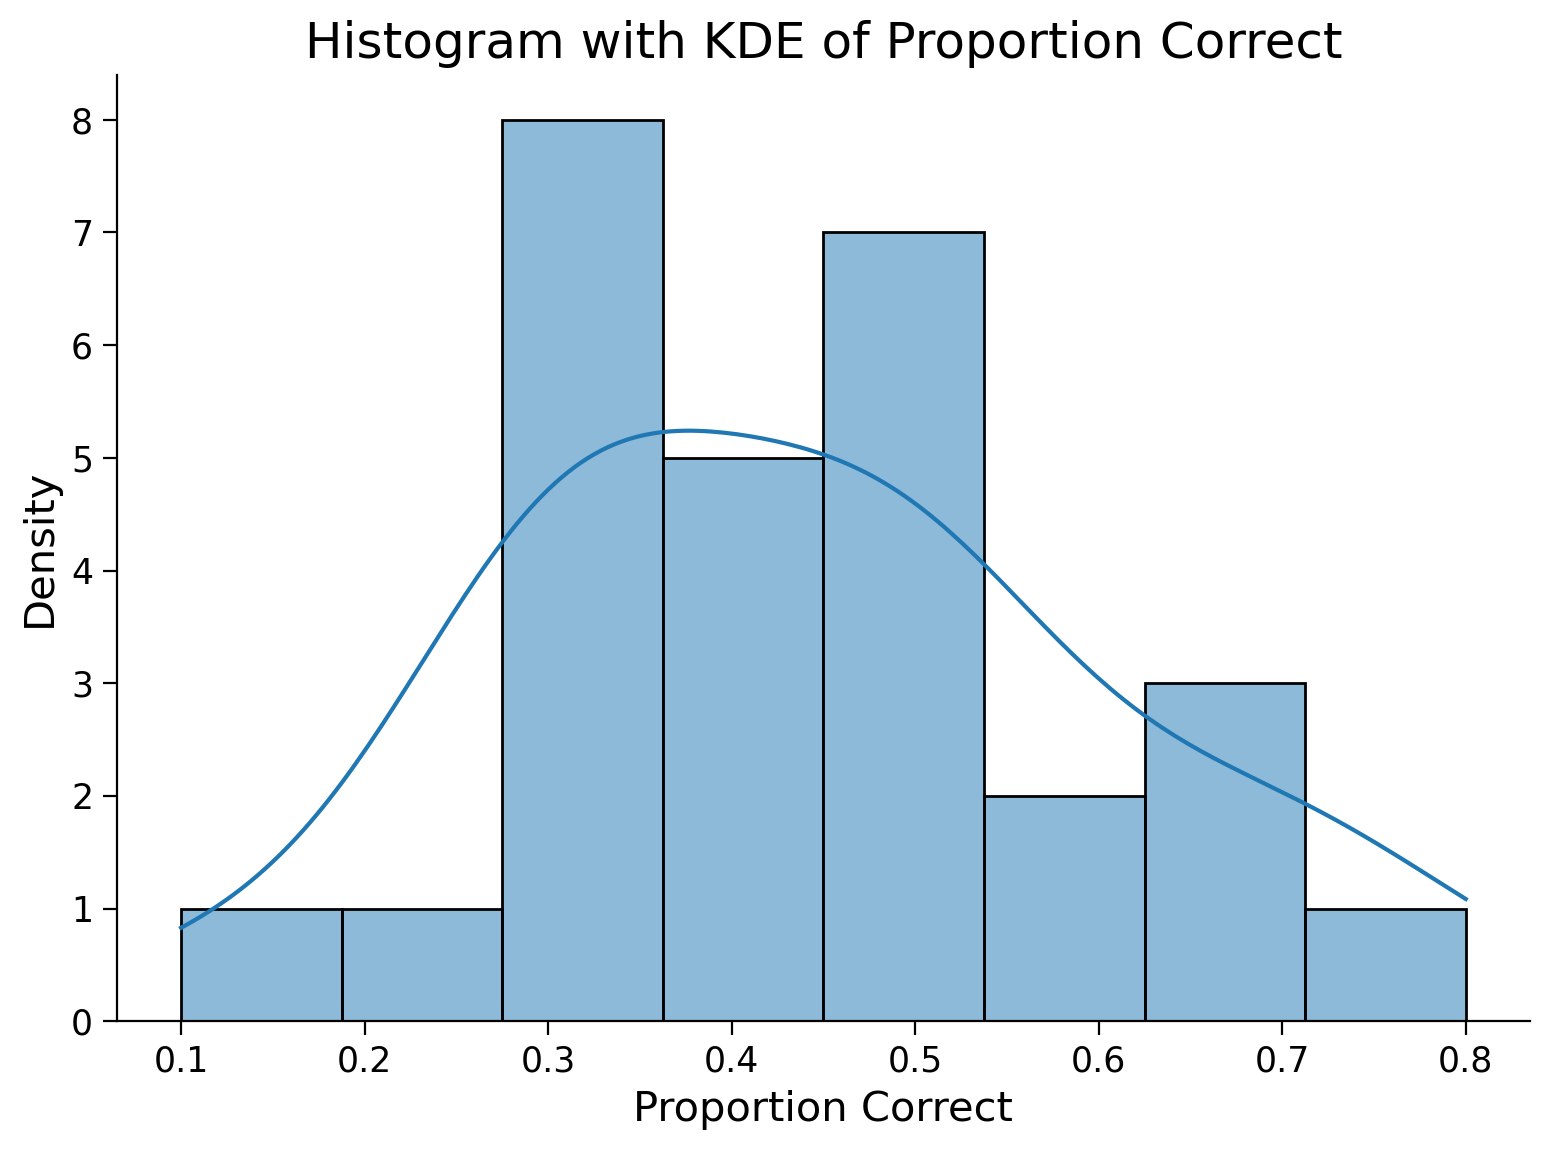

In [17]:
sns.histplot(data=tt_agg, x="proportion_correct", bins=8, kde=True)
plt.xlabel("Proportion Correct")
plt.ylabel("Density")
plt.title("Histogram with KDE of Proportion Correct")
plt.show()

Se consideriamo il numero di risposte corrette come "successi", il modello di campionamento binomiale risulta essere una scelta naturale per questi dati. Osservando le proporzioni di risposte corrette, notiamo che alcuni operatori hanno tassi di risposte corrette molto più elevati rispetto ad altri. Ad esempio, la proporzione più alta di risposte corrette è 0.8 e la più bassa è 0.1. Se si assumesse una probabilità comune $p$ di risposte corrette per tutti i 28 operatori, tale modello non renderebbe conto dei dati in maniera adeguata. D'altra parte, se si creassero 28 modelli di campionamento binomiale separati, uno per ciascun operatore, e si effettuassero inferenze separate, si perderebbe la possibilità di utilizzare informazioni potenziali sul tasso di risposte corrette dell'operatore $j$ quando si conducono inferenze riguardanti un altro operatore $i$. 

Il modello gerarchico rappresenta una via di mezzo tra l'approccio combinato e quello separato nella modellazione. Costruiamo il modello gerarchico partendo dall'assunzione che il numero di risposte corrette per ciascun operatore sia una variabile casuale Binomiale. Per ciascuno dei ventotto operatori possiamo dunque scrivere:

$$
y_i \sim Binomial(n_i, p_i),
$$

con $i = 0, \dots, 27$.

Quale distribuzione a priori per il parametro sconosciuto $p_i$ possiamo fissare una distribuzione Beta di parametri $a$ e $b$:

$$
p_i \sim Beta(a, b).
$$

Va notato che, in questo modo, gli iperparametri $a$ e $b$ sono condivisi tra tutti gli operatori. Se $a$ e $b$ sono noti, allora la distribuzione a posteriori per il parametro $p$ è una distribuzione Beta:

$$
p_i \mid y_i \sim Beta(a + y_i, b + n_i - y_i). 
$$

Nel caso generale in cui gli iperparametri $a$ e $b$ sono incogniti, è necessario fissare una distribuzione a priori per ciascuno di essi. 

Applichiamo dunque il modello gerarchico descritto sopra ai dati del *therapeutic touch*. Iniziamo a calcolare il numero di risposte corrette di ciascun operatore.

In [18]:
result = tt_dat.groupby("s")["y"].sum().reset_index()
y = result["y"]
print(*y)

1 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 6 6 7 7 7 8


In media, gli operatori rispondono correttamente 4.39 volte su 10.

In [19]:
y.mean()

4.392857142857143

Creiamo inoltre il vettore `N` che fornisce il numero di prove per ciascun operatore.

In [20]:
N = tt_dat.groupby("s")["y"].count() 
N

s
S01    10
S02    10
S03    10
S04    10
S05    10
S06    10
S07    10
S08    10
S09    10
S10    10
S11    10
S12    10
S13    10
S14    10
S15    10
S16    10
S17    10
S18    10
S19    10
S20    10
S21    10
S22    10
S23    10
S24    10
S25    10
S26    10
S27    10
S28    10
Name: y, dtype: int64

Scriviamo ora il modello gerarchico Beta-Binomiale con la sintassi PyMC.

In [21]:
with pm.Model() as model:
    alpha = pm.Gamma("alpha", 8, 2)
    beta = pm.Gamma("beta", 27, 5)
    p = pm.Beta("p", alpha, beta, shape=len(y))
    Y_obs = pm.Binomial("Y_obs", n=N, p=p, observed=y)

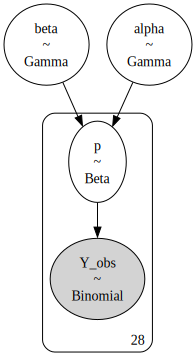

In [22]:
pm.model_to_graphviz(model)

La verosimiglianza `Y = pm.Binomial("Y", n=N, p=xs, observed=y)` ci dice che i dati osservati (ciascuno dei 28 valori del vettore `y`) sono una variabile casuale binomiale che rappresenta il numero di successi (risposte corrette) su N prove (in questo caso, `N` è sempre uguale a 10). La probabilità `p` di successo (risposta corretta) per ciascuna prova è modellata dalla distribuzione Beta con parametri alpha e beta: `p = pm.Beta("p", alpha, beta, shape=len(y))`.

Nel modello, la specifica `shape=len(y)` per la variabile casuale `p` indica che viene modellata una distribuzione Beta separata per ciascun elemento in `y`. Questo significa che il modello stimerà una probabilità `p` diversa per ciascun cluster o elemento in `y`. Ciò ci permette di modellare situazioni in cui le probabilità di successo possono differire tra i diversi cluster di dati (in questo caso, gli operatori), catturando l'eterogeneità tra le diverse unità di osservazione.

I parametri `alpha` e `beta` della distribuzione Beta usata per modellare `p` sono sconosciuti. Dunque, a ciascuno di essi imponiamo una distribuzione a priori. La scelta delle distribuzioni a priori per i parametri `alpha` e `beta` è basata sulle seguenti considerazioni.

La probabilità di successo media del gruppo di operatori è 0.44. L'incertezza su questa probabilità viene descritta dal modello mediante una distribuzione Beta. I parametri della distribuzione Beta per avere una media di 0.44 sono approssimativamente $\alpha = 4$ e $\beta = 5.4$. I parametri di una distribuzione Gamma con media 4 sono $\alpha = 8$ e $\beta = 2$. I parametri di una distribuzione Gamma con media 5.4 sono $\alpha = 27$ e $\beta = 5$.

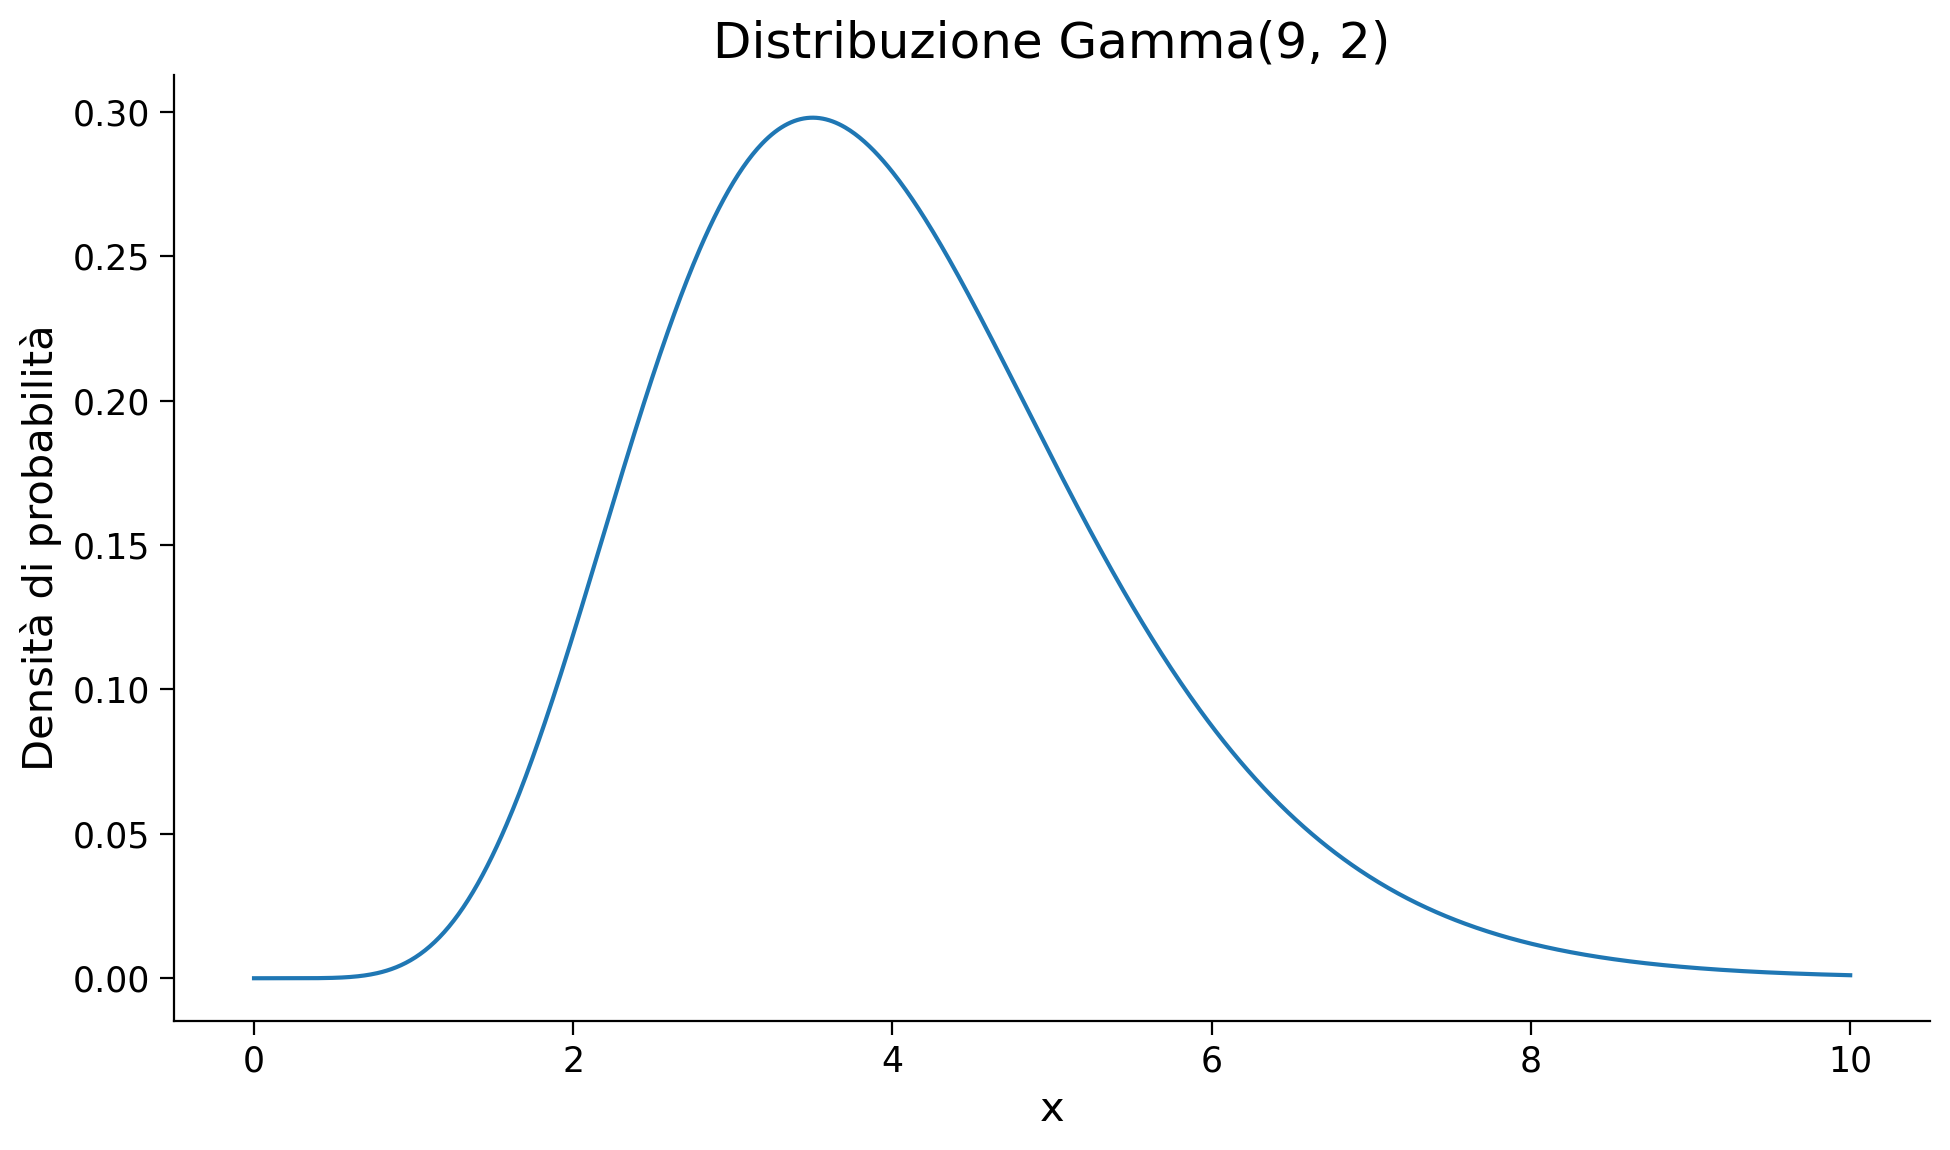

In [19]:
a = 8
b = 2

x = np.linspace(0, 10, 1000)  # Valori x da 0 a 10
yy = stats.gamma.pdf(x, a, scale=1/b)  # Funzione di densità di probabilità Gamma

plt.figure(figsize=(10, 6))
plt.plot(x, yy)
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.title('Distribuzione Gamma(9, 2)');

Eseguiamo ora il campionamento.

In [24]:
with model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


Nel modello beta-binomiale gerarchico, tutte le probabilità di successo dei diversi operatori vengono modellate utilizzando la stessa distribuzione a priori. Questo significa che si assume che le probabilità di successo di ciascun operatore derivino da una distribuzione comune. Di conseguenza, le stime individuali delle probabilità di successo per ogni operatore saranno "shrunk" o "ritratte" verso il valore medio della distribuzione comune. Questo fenomeno è noto come "shrinkage". In altre parole, le stime tendono ad avvicinarsi alla media del gruppo, piuttosto che essere stime completamente indipendenti. Questo effetto di "shrinkage" permette di ottenere stime più stabili e generalizzabili, soprattutto quando i campioni per alcuni operatori sono limitati o poco informativi.

Questo effetto di shrinkage ha un importante vantaggio: migliora la precisione delle stime individuali. Le stime aggregate attraverso l'informazione del gruppo possono essere più affidabili e robuste rispetto alle stime basate su un numero limitato di dati. Di conseguenza, il modello beta-binomiale gerarchico permette di ottenere stime più accurate e stabili per le probabilità di successo degli operatori, tenendo conto sia delle informazioni specifiche di ogni operatore che delle informazioni comuni a tutto il gruppo -- si confrontino le stime a posteriori della probabilità di successo `xs` con le stime della probabilità di successo calcolate separatamente per ciascun operatore (si veda la tabella precedente).

Esaminiamo dunque le stime a posteriori della probabilità di successo di ciascun operatore.

In [25]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,4.58,0.85,3.09,6.27
beta,5.77,0.91,4.12,7.48
p[0],0.27,0.10,0.09,0.46
p[1],0.32,0.10,0.14,0.52
p[2],0.37,0.11,0.18,0.58
p[3],0.37,0.11,0.18,0.58
p[4],0.37,0.11,0.17,0.57
p[5],0.37,0.11,0.18,0.57
p[6],0.37,0.11,0.16,0.56
p[7],0.37,0.11,0.18,0.57


Nella figura seguente, i medesimi dati sono rappresentati mediante un "forest plot" del parametro `p`, che rappresenta la probabilità di successo, insieme all'intervallo di credibilità Highest Density Interval (HDI) al 94%. Notiamo che per un solo operatore, l'intervallo non contiene il valore 0.5. Inoltre, per questo operatore, l'intervallo di credibilità è inferiore a 0.5, suggerendo che ha fornito un numero di risposte "sbagliate" superiore a quanto ci si potrebbe aspettare casualmente. 

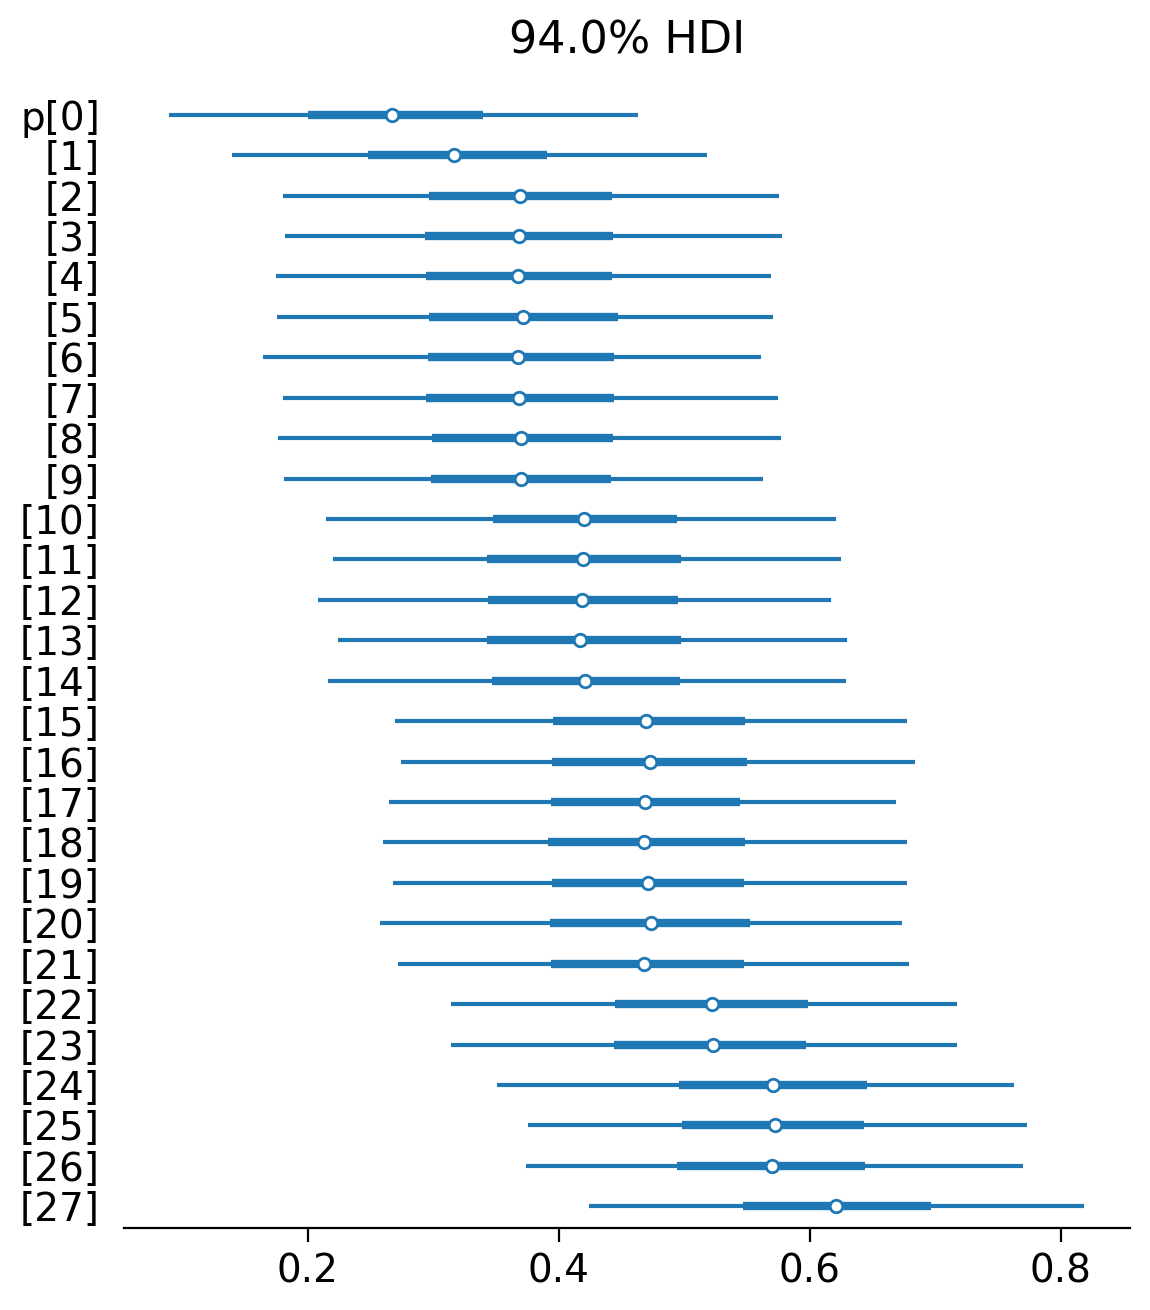

In [26]:
samples_p = trace.posterior["p"]
az.plot_forest(samples_p, combined=True, hdi_prob=0.94);

Esaminiamo la distribuzione a posteriori dei parametri `alpha` e `beta`.

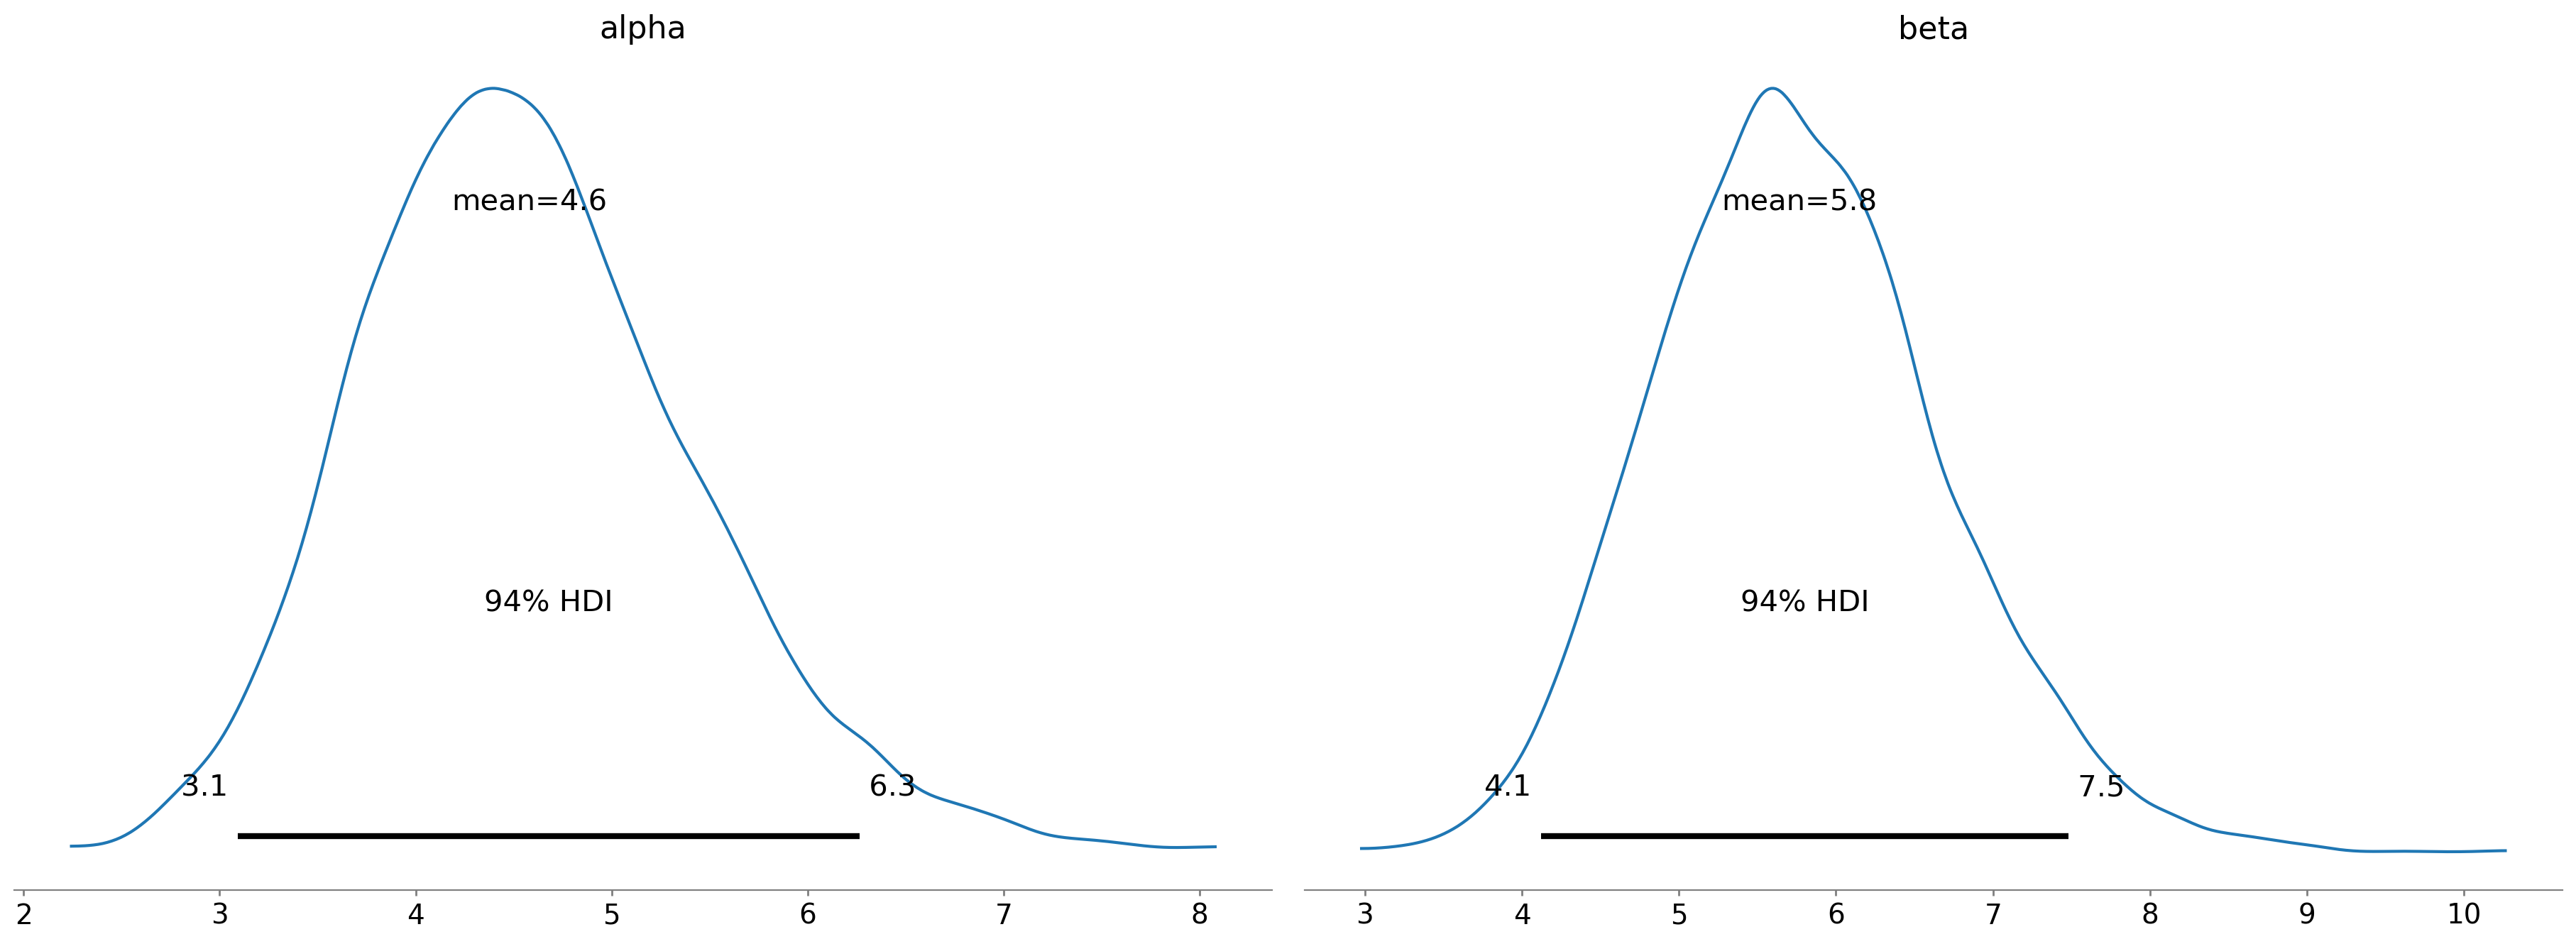

In [27]:
with model:
    az.plot_posterior(trace, var_names=["alpha", "beta"])


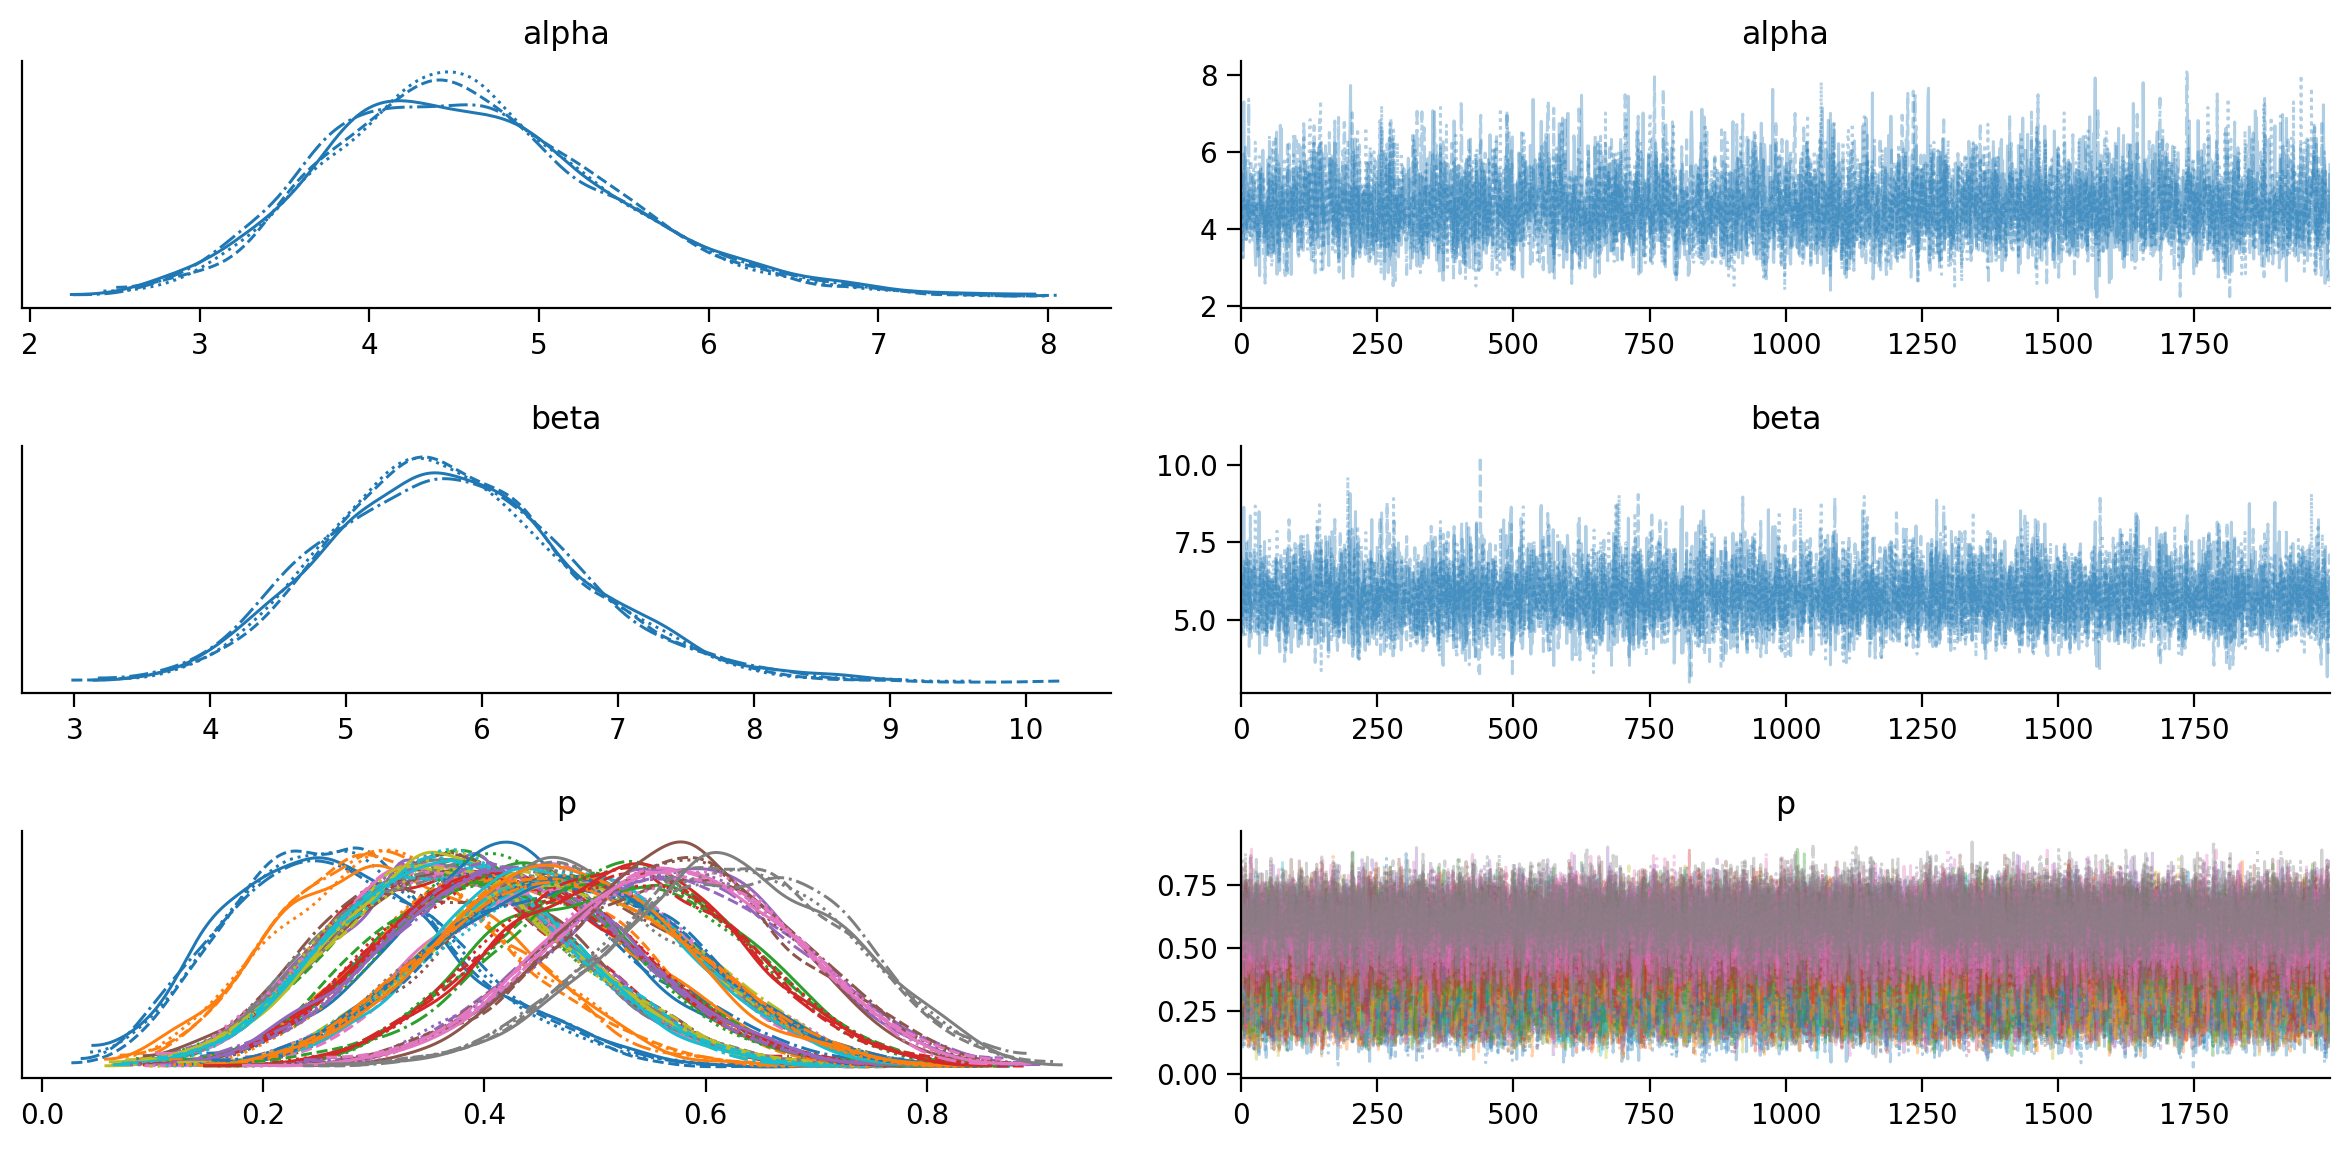

In [28]:
with model:
    az.plot_trace(trace)

Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

Iniziamo a recuperare le stime a posteriori di  `alpha` e `beta`.

In [29]:
alphas = trace.posterior["alpha"]
betas = trace.posterior["beta"]

print(alphas)

<xarray.DataArray 'alpha' (chain: 4, draw: 2000)>
array([[4.66832084, 4.64789885, 4.85522171, ..., 4.27261938, 4.42494306,
        5.67841199],
       [5.16521027, 3.70391653, 3.8022944 , ..., 3.71528203, 4.77965951,
        3.19891865],
       [4.38384526, 5.00491937, 5.44021082, ..., 2.77441728, 2.94971021,
        2.50244374],
       [5.54871423, 4.49882041, 3.27012689, ..., 3.69217888, 5.4926365 ,
        4.15568018]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999


Dato che ciascuna coppia di parametri  `alpha` e `beta` definisce la distribuzione a posteriori Beta, calcoliamo la media della distribuzione Beta definita da ciascuna coppia di valori `alpha` e `beta`. 

In [30]:
# Function to calculate the mean of a Beta distribution
def beta_mean(alpha, beta):
    return alpha / (alpha + beta)

# Calculate the means for each pair of alpha and beta
sample_posterior_x_means = np.array([beta_mean(a, b) for a, b in zip(alphas, betas)])

Ci sono 8000 di queste medie.

In [31]:
sample_posterior_x_means.shape

(4, 2000)

In [32]:
sample_posterior_x_means

array([[0.43829194, 0.45314706, 0.42313608, ..., 0.47105684, 0.49910315,
        0.46992897],
       [0.42272506, 0.44960412, 0.41224714, ..., 0.46050004, 0.47198069,
        0.40098165],
       [0.44064942, 0.45903994, 0.49044877, ..., 0.41764851, 0.42378937,
        0.3872149 ],
       [0.51479465, 0.49396299, 0.42077661, ..., 0.43950638, 0.4363473 ,
        0.44493239]])

In [33]:
print(sample_posterior_x_means.mean())

0.44187967370948955


Con questi 8000 valori a posteriori della media della distribuzione Beta che rappresenta il "meccanismo generatore" da cui i valori `p` di ciascun operatore vengono tratti, generiamo una densità empirica da cui è anche possibile calcolare l'intervallo che contiene il 94% dei valori della distribuzione.

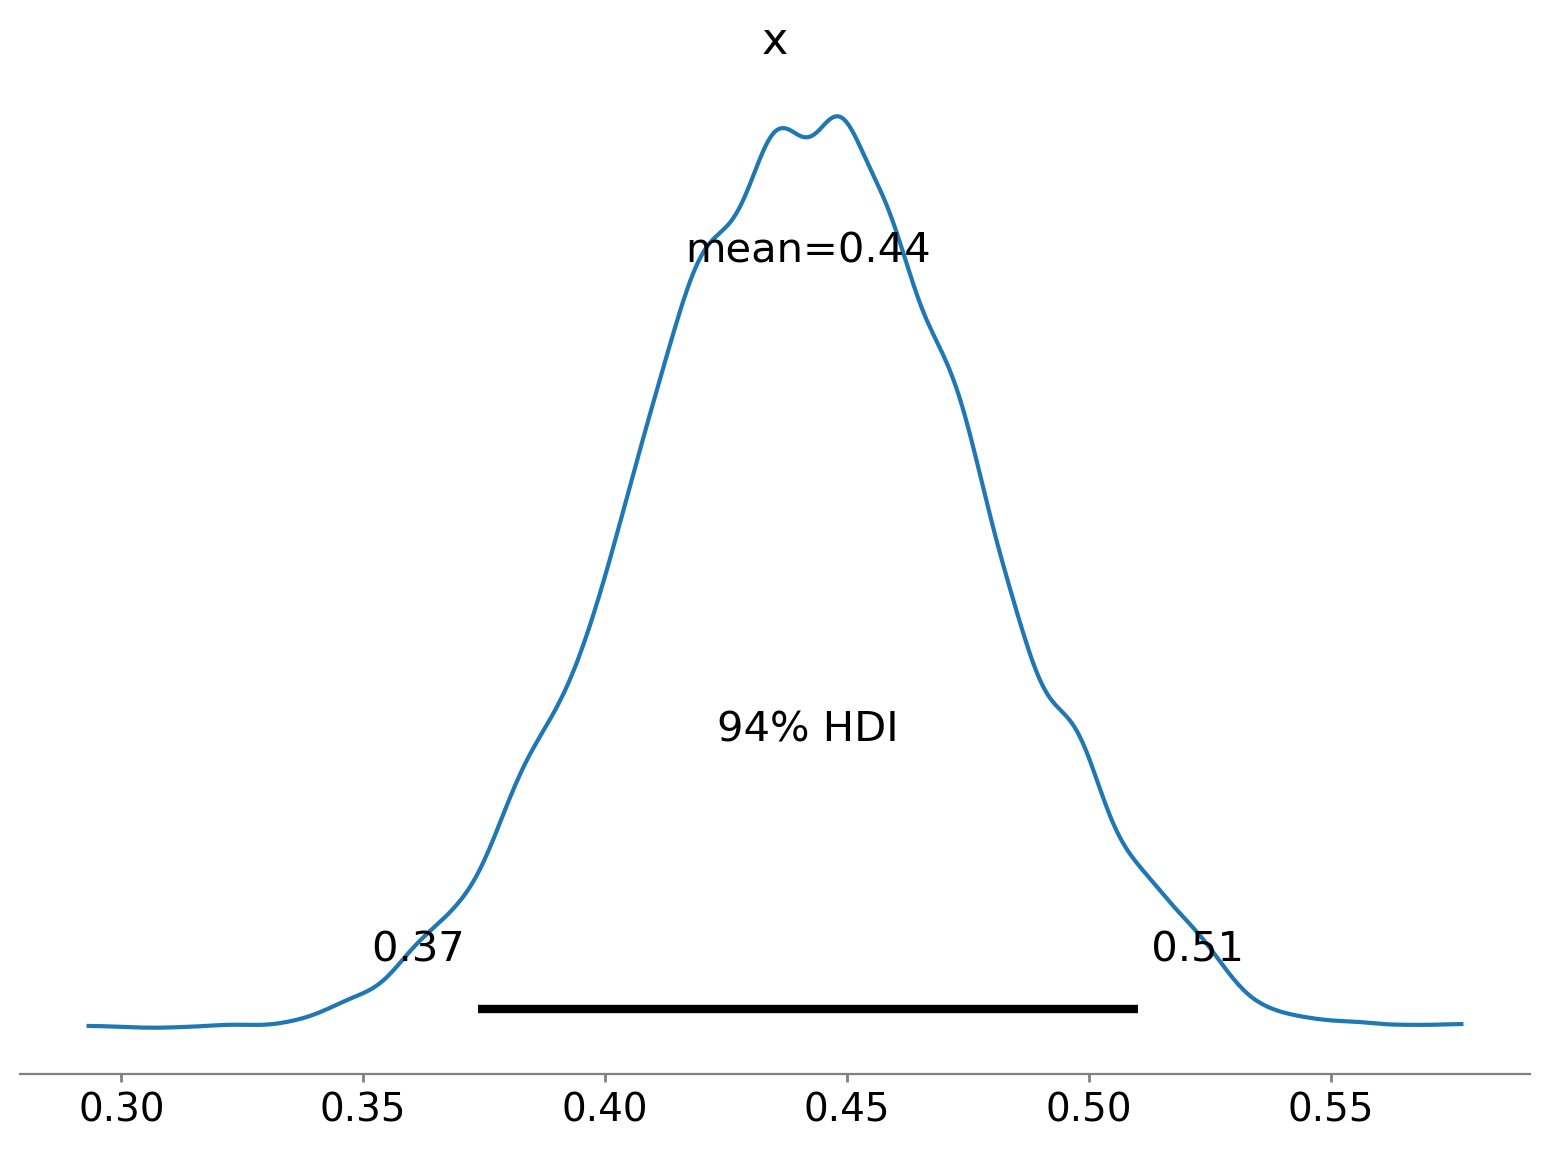

In [34]:
with model:
    az.plot_posterior(sample_posterior_x_means)

L'intervallo [0.37, 0.51] rappresenta l'intervallo di credibilità al 94% per la probabilità di risposta corretta `p`, considerando l'insieme del gruppo degli operatori. Questo intervallo ci fornisce un'indicazione sulla variabilità delle probabilità di successo tra gli operatori, considerando sia le differenze tra di loro che le somiglianze all'interno del gruppo.

Poiché l'intervallo di credibilità include il valore 0.5, possiamo concludere che non ci sono evidenze credibili che gli operatori, considerati nel loro insieme, siano in grado di "percepire il campo energetico di una persona senza vedere le mani" ad un livello diverso rispetto a quello che ci si potrebbe aspettare dal caso soltanto. 

## Considerazioni conclusive

Il modello gerarchico beta-binomiale rappresenta uno strumento fondamentale per l'analisi di dati binomiali provenienti da gruppi o categorie diverse, consentendo di trattare dati complessi in modo integrato. Questo modello ci permette di studiare le probabilità di successo in modo unificato, considerando sia le caratteristiche specifiche di ogni gruppo che le somiglianze tra di essi. L'approccio gerarchico aumenta la precisione delle stime e ci aiuta a comprendere meglio le differenze tra i gruppi e le tendenze comuni a tutti. Questo rende il modello gerarchico beta-binomiale uno strumento importante per la valutazione e l'interpretazione di dati binomiali raggruppati.

## Watermark

In [4]:
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Aug 14 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

scipy     : 1.11.1
requests  : 2.31.0
pandas    : 2.0.3
seaborn   : 0.12.2
numpy     : 1.25.2
matplotlib: 3.7.2
arviz     : 0.16.1
pymc      : 5.7.2

Watermark: 2.4.3

